<a href="https://colab.research.google.com/github/NDU-CSC413/cuda1/blob/master/cuda1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Google colab creates a Linux instance that can be accesses from a Jupyter notebook. A Jupyter notebook consists of a sequence of cells. For our purpose there are two types of cells: **code** and **text**. For both cases you can "execute" the cell by pressing SHIFT-ENTER. For a text cell it will format it. You can always edit a text cell by double-clicking it.
A code cell executes Python by default. In our case we would like to edit c++ (with CUDA extensions) files, compile and run them.

First make sure that the runtime is GPU. From the menu choose Runtime->change runtime type-> Hardware accelerator choose GPU.

We can run arbitrary shell commands by either preceding each one of them with a "!" or we can use the magic characters "%%bash" in the begining of the cell.

As a first example let us determine the type of GPU that the instance has using the nvidia-smi command

In [ ]:
%%bash
nvidia-smi

# Example 0: Querying the device

In [ ]:
%%writefile device.cu
#include <iostream>


int main()
{
	int device;

	cudaDeviceProp properties;
	cudaError_t err = cudaSuccess;
	err = cudaGetDevice(&device);
	err = cudaGetDeviceProperties(&properties, device);
	std::cout << "processor count" << properties.multiProcessorCount << std::endl;
	std::cout << "warp size " << properties.warpSize << std::endl;
	std::cout << "name=" << properties.name << std::endl;
	std::cout << "Compute capability " << properties.major << "." << properties.minor << "\n";
	std::cout << "shared Memory/SM " << properties.sharedMemPerMultiprocessor
		<< std::endl;

	if (err == cudaSuccess)
		printf("device =%d\n", device);
	else
		printf("error getting deivce\n");
	return 0;
}

In [ ]:
!nvcc -o device device.cu -run

## Example1

To write code, create a code cell and write %%writefile filename.cu at the beginning. To actually create/modify the file "run" the cell

In [ ]:
%%writefile example1.cu
#include <iostream>
__global__ void kernel(){
  printf("Hello from GPU\n");
}
int main(){
    kernel<<<1,2>>>();
    cudaDeviceSynchronize();

    
}

At this point we can open the file from the left pane. Click on the folder icon in the left pane to see all the files.
Alternatively, we can list them using the unix "ls" command.

**IMPORTANT**: any file created from a Jupyter notebook will be lost once the instance is restarted.

A colab instance is a actually a VM running linux so each time it starts "from scratch". If you want to save files, mount your Google drive from the left pane.

In [ ]:
!ls -la

CUDA code files MUST have the extension .cu, and it is compiled with the NVIDIA nvcc compiler

In [ ]:
!nvcc example1.cu -o example1 
!./example1

## Example2

Most of the examples in the workshop use **managed memory**. In the following examples we will manage the memory manually. We will revisit managed memory later.

Before computing on the GPU we need to transfer the data from host memory to device memory. Once the computation is done we transfer it back to the host.
Below is a simple example of that process.

NOTE: ```cudaMemcpy``` is **synchronous**, meaning the host code will **block** until the memory transfer is complete.





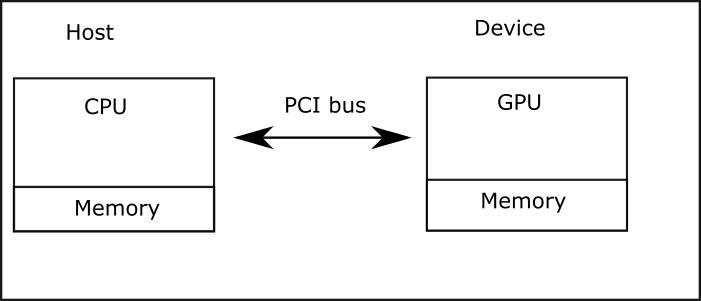

In [ ]:
%%writefile example2.cu
#include <iostream>
__global__ void kernel(int *x,int *y,int *z){
    *z=*x+*y;
}
int main(){
    int a=1,b=2,c=0; //host variables
    int *d_a,*d_b,*d_c;//will hold device addresses
    // allocate memory for one integer and store the
     // address in d_a 
    cudaMalloc(&d_a,sizeof(int));
    cudaMalloc(&d_b,sizeof(int));
    cudaMalloc(&d_c,sizeof(int));
    // copy the value of a and b
    // TO device FROM host
    cudaMemcpy(d_a,&a,sizeof(int),cudaMemcpyHostToDevice);
    cudaMemcpy(d_b,&b,sizeof(int),cudaMemcpyHostToDevice);
    kernel<<<1,1>>>(d_a,d_b,d_c);
    // copy the result TO host FROM device
    cudaMemcpy(&c,d_c,sizeof(int),cudaMemcpyDeviceToHost);
    cudaDeviceSynchronize();
    
std::cout<<"value of c is "<<c<<"\n";
    
}

In [ ]:
!nvcc example2.cu -o example2
!./example2

# More details
Below is a similar code but with more details. In particular, it describes what and what cannot be accessed from the device and explains the \_\_device\_\_ and \_\_global\_\_ modifiers.

In [ ]:
%%writefile example3.cu
#include <iostream>

/**
 * @brief constant global variables are accessible from both the CPU and GPU.
 * if the constant modified is removed from the declaration of g the compiler 
 * will give an error.
 * NOTE: global variables in the sense of C++ are DIFFERENT than the __global__ 
 * modifier.
 * NOTE: GPU access of const global variables other than int in Windows gives an error
 * on Linux it works. 
 */
const int g=10;
#ifdef WINDOWS
__device__ 
#endif 
const float a=2.3;

/* __device__ means a function called from the device
* AND runs on the device
*/

__device__ float useless(){
    return 2*a;
}

/* __global__ means a function called from the host 
 * and runs on device
 */
__global__ void example1(int *address){
    *address=useless()*g*17;

}


int main(){
    int x;
    /* variable that holds device address */
    int * device_address;
    /* allocate space for one int on the device 
     * and store the allocated address in device_address
     * NOTE the passing of the address of device_address variable
     */
    cudaMalloc(&device_address,sizeof(int));
    /* set the value at device address to 17 using a kernel launch*/
    std::cout<<"address of x="<<std::hex<<&x<<"\n";
    std::cout<<"device address="<<device_address<<"\n";
    /* launch function example1 with one block containing 1 thread 
     * @NOTE: all kernel launches are asynchronous
     * they return immediately to host code
     **/
    example1 <<<1,1>>>(device_address);
    /* copy the result back from device to host */
    cudaMemcpy(&x,device_address,sizeof(int),cudaMemcpyDeviceToHost);
    cudaFree(device_address);
    std::cout<<"The value of x="<<std::dec<<x<<"\n";

}

## Example4
This is the first example where we use parallelism, computing the sum of two arrays.
The computation is performed where each thread computes the sum of two elements. To accomplish that we map the thread id to the array index. In this example we use a __single__, __linear__, block therefore the thread id is equal to the builtin variable threadIdx.x

# Thread Hierarchy and Stream Multiprocessors

A CUDA device contains an array of streaming multiprocessors (SM).In the CUDA programming model, threads are organized into thread blocks. Each thread block runs independently on a different SM.

Note: the assignment of blocks to SMs is static. Once the blocks are assigned to SMs they will not move even if some SMs finish running their blocks and become idle.

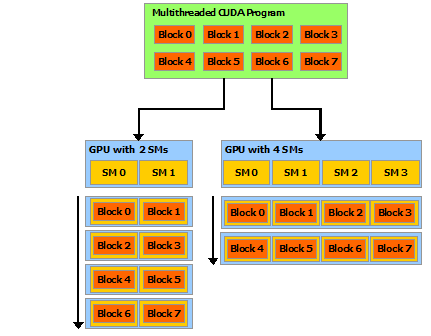

The threads in a kernel execution is organized in a hierarchy. The totality of the threads is called a **grid**. A grid is composed of **blocks** and each block is composed of **threads**.

Below is an example of a **linear** grid. In general the blocks and threads can be organized in 3-d.

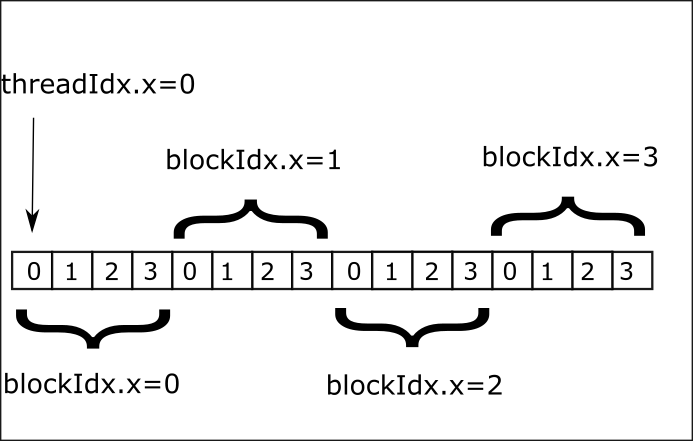

In [ ]:
%%writefile example4.cu
/**
 * @file example4.cu
 * @author Hikmat Farhat (hfarhat@ndu.edu.lb)
 * @brief SAXPY example in CUDA
 * given vectors X and Y and a constant a compute a*X+Y
 * @version 0.1
 * @date 2021-12-20
 * 
 * @copyright Copyright (c) 2021
 * 
 */
#include <iostream>


__global__ void saxpy(float *z,float *x,float *y,float a,int n){
   
     int i=blockDim.x*blockIdx.x+threadIdx.x;
     if( i<n)
        z[i]=a*x[i]+y[i];

}
int main(){
    /* number of elements */
    const int n=1<<20;
    const float a=3.0;
/* create 3 arrays on host */
    float *x, *y, *z;
    x=(float *)malloc(n*sizeof(float));
    y=(float *)malloc(n*sizeof(float));
    z=(float *)malloc(n*sizeof(float));
/* populate x and y */
    for(int i=0;i<n;++i){
        x[i]=2;
        y[i]=4;
    }
/* create 3 arrays on device */
    float *dx,*dy,*dz;
    cudaMalloc(&dx,n*sizeof(float));
    cudaMalloc(&dy,n*sizeof(float));
    cudaMalloc(&dz,n*sizeof(float));
/* transfer the values of x,y to device */
    cudaMemcpy(dx,x,n*sizeof(float),cudaMemcpyHostToDevice);
    cudaMemcpy(dy,y,n*sizeof(float),cudaMemcpyHostToDevice);
    /** 1-d grid 
     * in general type dim3 has 3 values (x,y,z)
     * when omitted each d defaults to 1
     * e.g. dim3 a(256)=a(256,1,1)
     * dim3 b(256,128)=b(256,128,1)
     ***/
     int block=256;
     int grid=(n+block-1)/block;
    //dim3 block (256);
    //dim3 grid ((n+block.x-1)/block.x,1);
    /**
     * NOTE:  kernel launch is asynchronous with respect
     * to host code whereas cudaMemcpy is blocking.
     */
    saxpy<<<grid,block>>>(dz,dx,dy,a,n); 
    saxpy<<<grid,block>>>(dz,dx,dy,a,n); 

    cudaError_t e=cudaGetLastError();
    if(e!=cudaSuccess){
        std::cout<<cudaGetErrorString(e)<<"\n";
    }
/* transfer the result back to host */
    cudaMemcpy(z,dz,n*sizeof(float),cudaMemcpyDeviceToHost);
/* check if the result is correct. We expect all values 
 * of z=10
 */
    int sum=0;
    for(int i=0;i<n;++i)
        sum+=z[i];
    if (sum!=n*10)std::cout<<"sum error"<<sum<<"\n";
    else
        std::cout<<"check passed. Sum= "<<sum<<"\n";
    free(x);
    free(y);
    free(z);
    cudaFree(dx);
    cudaFree(dy);
    cudaFree(dz);
}

In [ ]:
!nvcc example4.cu -o example4 -run

# Thread Id mapping

So far we have mapped a thread id to its index in a linear fashion. For convenience, CUDA allows us to organize the threads in 2-d and 3-d.
For 2-d, if the block is of size $(D_x,D_y)$ and the index of a thread is $(x,y)$ then its id is

$$id=x+y\cdot D_x$$

**NOTE**:  for consistancy with the 1-d representation, and unlike the usual matrix indexing, the $x$ dimension refers to the column and $y$ refers to the row. A example mapping is shown in the figure below.

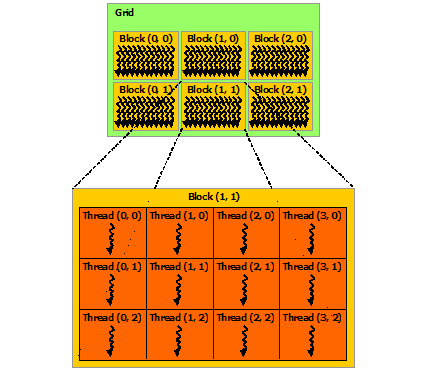

# dim3
CUDA defines a ```dim3``` type that has 3 components. For example

```dim3 block(2,2,2)``` 

is a 3-d organization of threads in a block. We can refer to each dimension with ```block.x```,```block.y```,```block.x```

Furthermore, any omitted dimension defaults to 1. For example
```dim3 block(2,2)``` is equivalent to ```dim3 block(2,2,1)```
and
```dim3 block(2)``` is equivalent to ```dim3 block(2,1,1)```

# Allocating memory for 2d arrays

The easiest way to use dynamic 2d arrays is to declare them as ```float **``` as show in the code below. 

In [ ]:
%%writefile 2d-array.cpp
#include <iostream>
const size_t width=3;
const size_t height=2;

int main(){
    float **a;
    float **b;
    a=(float **)malloc(height*sizeof(float *));
    
    for(int row=0;row<height;++row){
        a[row]=(float *)malloc(width*sizeof(float));
    }
    for(size_t i=0;i<width;++i){
        for(size_t j=0;j<height;++j){
            a[i][j]=i+j;
        }
    }
  
}

In [ ]:
!g++ 2d-array.cpp -o 2d-array
!./2d-array

The above method is clumsy especially when using a GPU. Recall that data must be transferred from the CPU to GPU for computation. Using the ```float **``` declaration would create  multiple, **non-contiguous**, memory areas, one for each "row". This means we must do multiple memory copies between CPU and GPU.

A better approach would be to  create a single memory space and divide it between rows as shown below

In [ ]:
%%writefile 2d-array2.cpp

#include <iostream>
const int height=2;
const int width=3;
int main(){
        float *buf=(float *)malloc(height*width*sizeof(float));

        float **a=(float **)malloc(height*sizeof(float *));

        for(int row=0;row<height;row++){
                a[row]=buf+row*width;
        }
        
        for(int row=0;row<height;++row){
                for(int col=0;col<width;++col){
                        a[row][col]=row+col;
                }}

        for(int row=0;row<height;++row){
                for(int col=0;col<width;++col){
                        std::cout<<a[row][col]<<",";
                }
                std::cout<<"\n";
        }

}

In [ ]:
!g++ 2d-array2.cpp -o 2d-array2
!./2d-array2

We can make our life a little easier by defining the 2-d array as an array of pointers to arrays as shown below.

In [ ]:
%%writefile matrix_add2.cu
/**
 * @file example5.cu
 * @author Hikmat Farhat (hfarhat@ndu.edu.lb)
 * @brief Simple matrix addition
 * @version 0.1
 * @date 2021-12-30
 * 
 * @copyright Copyright (c) 2021
 * 
 */
#include <iostream>
const size_t width=1<<11;
const size_t height=1<<11;

using arr_t = float[width];

__global__ void matrix_add(arr_t *c,arr_t *a,arr_t *b,size_t width,size_t height){

    size_t idx=blockIdx.x*blockDim.x+threadIdx.x;
    size_t idy=blockIdx.y*blockDim.y+threadIdx.y;
    if( idx<width && idy <height)
        c[idy][idx]=a[idy][idx]+b[idy][idx];
}
int main(){
    arr_t *a,*b,*c;
   arr_t *da,*db,*dc;
    a=(arr_t *)malloc(height*sizeof(arr_t));
    b=(arr_t *)malloc(height*sizeof(arr_t));
    c=(arr_t *)malloc(height*sizeof(arr_t));

    cudaMalloc(&da,height*sizeof(arr_t));
    cudaMalloc(&db,height*sizeof(arr_t));
    cudaMalloc(&dc,height*sizeof(arr_t));
    for(size_t i=0;i<width;++i){
        for(size_t j=0;j<height;++j){
            a[i][j]=1;
            b[i][j]=2;
        }
    }
    cudaMemcpy(da,a,height*sizeof(arr_t),cudaMemcpyHostToDevice);
    cudaMemcpy(db,b,height*sizeof(arr_t),cudaMemcpyHostToDevice);
    

    dim3 block(32,32);
    dim3 grid((width+block.x-1)/block.x,  (height+block.y-1)/block.y);   
    std::cout<<"Grid size=("<<grid.x<<","<<grid.y<<")\n";
    cudaEvent_t kernel_start ,kernel_stop;
    cudaEventCreate(&kernel_start);
    cudaEventCreate(&kernel_stop);

    int num_trials=10;
    float total=0.0;
    for(int i=0;i<num_trials;++i){
    cudaEventRecord(kernel_start); 
    matrix_add<<<grid,block>>>(dc,da,db,width,height);
    cudaError_t e;
    e=cudaGetLastError();
    if(e!=cudaSuccess)
     std::cout<<cudaGetErrorString(e)<<"\n";
    cudaEventRecord(kernel_stop);    
    cudaEventSynchronize(kernel_stop);
    float time=0;
    cudaEventElapsedTime(&time,kernel_start,kernel_stop);
    total+=time;
    }
    cudaMemcpy(c,dc,height*sizeof(arr_t),cudaMemcpyDeviceToHost);
    std::cout<<"Time="<<total/num_trials<<"\n";
    bool e=false;
    for(size_t i=0;i<width;++i)
        for(size_t j=0;j<height;++j)
            if(c[i][j]!=3){
                e=true;
                break;
            }
    if (e==true)std::cout<<"error\n";
    cudaFree(a);
    cudaFree(b);
    cudaFree(c);
    free(a);
    free(b);
    free(c);
}

In [ ]:
!nvcc -o matrix_add2 matrix_add2.cu -run

# Matrix multiplication

Below is the code for "naive" matrix multiplication in CUDA. Unlike the previous examples, we represent a 2-d array as a 1-d array.

In [ ]:
%%writefile matrix_mult1.cu
#include <iostream>
#include <chrono>
using Duration = std::chrono::duration<double, std::milli>;

#define TIMEIT(dur,...)\
   {\
    auto start = std::chrono::high_resolution_clock::now();\
    __VA_ARGS__\
    auto end = std::chrono::high_resolution_clock::now();\
     dur = std::chrono::duration<double, std::milli>(end - start);\
}
/**
 *  mat_mult()->__global__ void
 * Matrix multiplication without using shared memory
 * @param da
 * @param db
 * @param dc
 * @param width
 * @return 
 */
__global__ void mat_mult(float* da, float* db, float* dc, int width) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    float result = 0;
    for (int k = 0; k < width; ++k) 
    {
        result += da[row * width + k] * db[k * width + col];
    }
    dc[row * width + col] = result;
}

float  time_kernel(float* da, float* db, float* dc, int width,
                         dim3 grid,dim3 block) {
    cudaEvent_t kernel_start, kernel_end;
    cudaEventCreate(&kernel_start);
    cudaEventCreate(&kernel_end);
    /* warmup call*/
    mat_mult <<<grid, block >> > (da, db, dc, width);
    float time = 0;
    float total = 0;
    const int num_trials=500;
    for (int i = 0; i < num_trials; ++i) {
        cudaEventRecord(kernel_start);
        mat_mult << <grid, block>> > (da, db, dc, width);
        cudaEventRecord(kernel_end);
        cudaEventSynchronize(kernel_end);
        cudaEventElapsedTime(&time, kernel_start, kernel_end);
        total += time;
    }
    /* average time in milliseconds */
    return total / num_trials;
}
int main() {
    const int matrix_w = 1<<10;
    const int msize = matrix_w * matrix_w;
    float* a, * b, * c;

    float* da, * db, * dc;
    a = (float*)malloc(msize * sizeof(float));
    b = (float*)malloc(msize * sizeof(float));
    c = (float*)malloc(msize * sizeof(float));
    for (int i = 0; i < msize; ++i) {
        a[i] = 1;
        b[i] = 1;
        c[i] = 0;
    }

    cudaMalloc(&da, msize * sizeof(float));
    cudaMalloc(&db, msize * sizeof(float));
    cudaMalloc(&dc, msize * sizeof(float));
    cudaMemcpy(da, a, msize * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(db, b, msize * sizeof(float), cudaMemcpyHostToDevice);


    /* total number of threads per block is 1024 which is the maximum */
    dim3 block(32, 32);
    dim3 grid((matrix_w+block.x-1)/block.x, (matrix_w+block.y-1)/block.y);
    float gpu_time = time_kernel(da, db, dc, matrix_w, grid, block);
    cudaMemcpy(c, dc, msize * sizeof(float), cudaMemcpyDeviceToHost);

    for (int i = 0; i < msize; ++i) {
        if (c[i] != matrix_w) {
            std::cout << "ERROR\n"; break;
        }
        else c[i] = 0;
    }
    std::cout << "Multiplicatio of two " << matrix_w << "x" << matrix_w << " matrices\n";
    std::cout << "GPU time " << gpu_time << "  milliseconds\n";
    cudaFree(da);
    cudaFree(db);
    cudaFree(dc);
    Duration d;
    TIMEIT(d,
        for (int i = 0; i < matrix_w; ++i) {
            for (int j = 0; j < matrix_w; ++j)
                for (int k = 0; k < matrix_w; ++k)
                    c[i * matrix_w + j] += a[i * matrix_w + k] * b[matrix_w * k + j];
        }
    )
	for (int i = 0; i < msize; ++i) {
		if (c[i] != matrix_w) {
			std::cout << "ERROR\n"; break;
		}
		else c[i] = 0;
	}
    std::cout <<"CPU time "<< d.count() << " milliseconds \n";
    std::cout << "gain = " << d.count()/gpu_time << "\n";
    

    free(a);
    free(b);
    free(c);


}

In [ ]:
!nvcc  -O2 -o matrix_mult1 matrix_mult1.cu -run

# CPU version
Below is the CPU version of the matrix multiplication, to be compiled using g++

In [ ]:
%%writefile matrix_cpu.cpp
#include <iostream>
#include <chrono>
using Duration = std::chrono::duration<double, std::milli>;

#define TIMEIT(dur,...)\
   {\
    auto start = std::chrono::high_resolution_clock::now();\
    __VA_ARGS__\
    auto end = std::chrono::high_resolution_clock::now();\
     dur = std::chrono::duration<double, std::milli>(end - start);\
}
int main() {
    const int matrix_w = 1024;
    const int msize = matrix_w * matrix_w;
    float* a, * b, * c;

    a = (float*)malloc(msize * sizeof(float));
    b = (float*)malloc(msize * sizeof(float));
    c = (float*)malloc(msize * sizeof(float));
    for (int i = 0; i < msize; ++i) {
        a[i] = 1;
        b[i] = 1;
        c[i] = 0;
    }

   
    Duration d;
    TIMEIT(d,
        for (int i = 0; i < matrix_w; ++i) {
            for (int j = 0; j < matrix_w; ++j)
                for (int k = 0; k < matrix_w; ++k)
                    c[i * matrix_w + j] += a[i * matrix_w + k] * b[matrix_w * k + j];
        }
    )
	for (int i = 0; i < msize; ++i) {
		if (c[i] != matrix_w) {
			std::cout << "ERROR\n"; break;
		}
		else c[i] = 0;
	}
    std::cout <<"CPU time "<< d.count() << " milliseconds \n";

    free(a);
    free(b);
    free(c);


}

In [ ]:
 !g++ -O2 matrix_cpu.cpp -o matrix_cpu
!./matrix_cpu

# Memory Hierarchy
The figure below shows the memory hierarchy for a typical NVIDIA GPU. Scalar variables without qualifiers are stored in registers, arrays in global/local memory. Variables preceded with __shared__ and __constant__ are stored in shared and constant memory respectively.

What concerns us in this section is that shared memory, being on chip (typically 64KB), is much faster to access than DRAM.


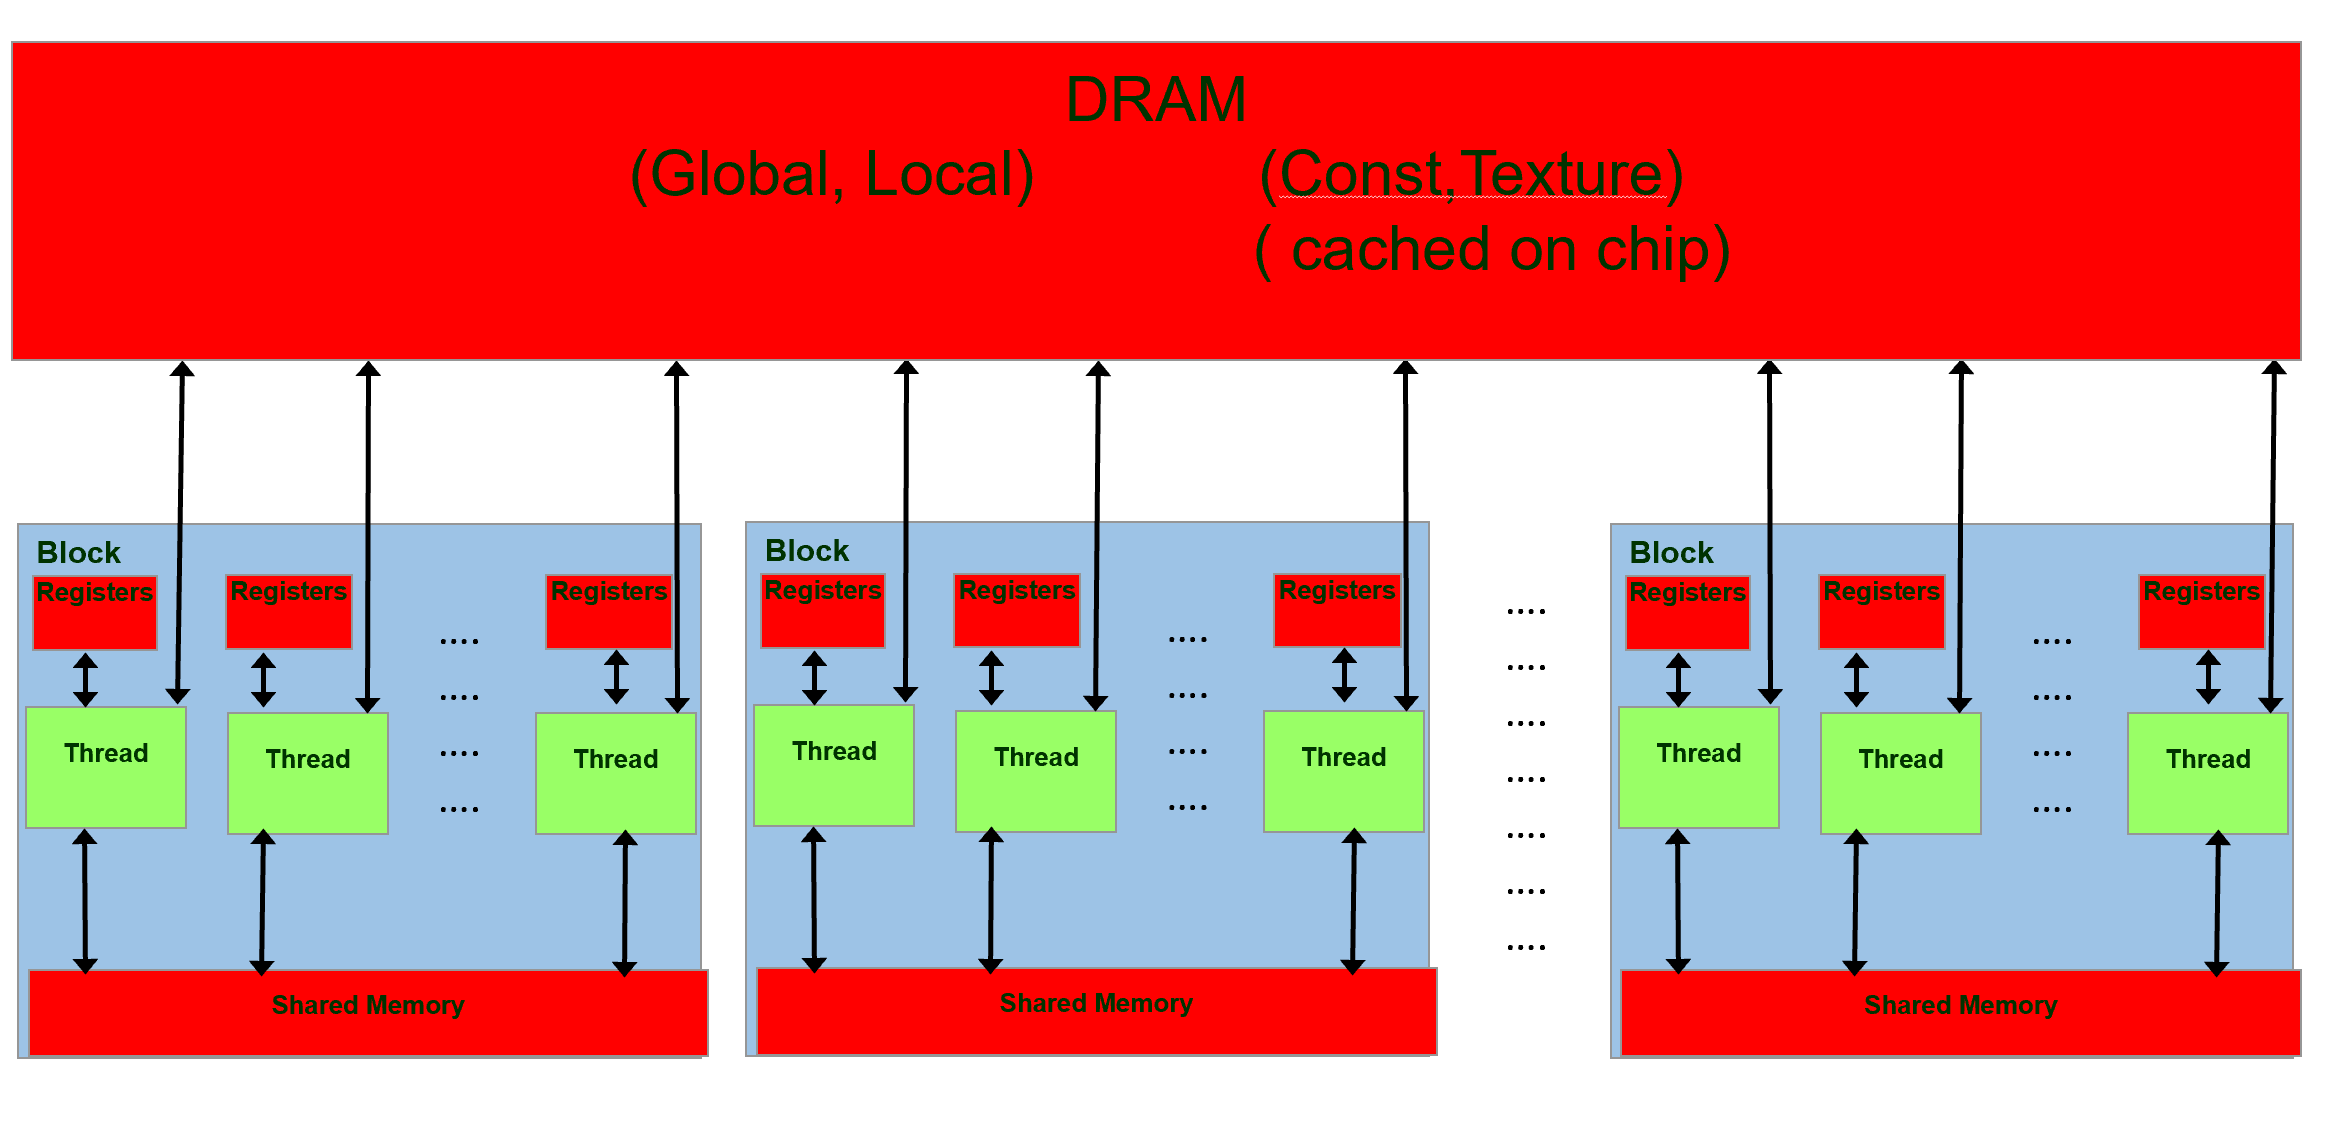

The figure above gives a clear picture of the way blocks are handled, each block runs independently on an SM. An important intrinsic primitive provided by CUDA is the __syncthread() call. It acts like a barrier for all threads in a block.

We will illustrate the above concepts with an implementation of the reduce operation. It is easier to visualize the reduce operation as a binary tree as in the example below.

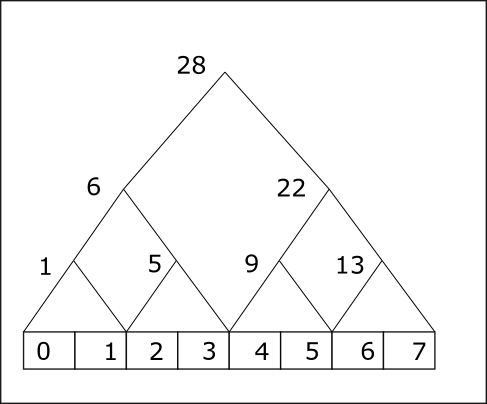

In [ ]:
%%writefile reduction.cu
#include <iostream>

#define THREADS_PER_BLOCK 1024
using Long= double;


__global__ void simple_reduction(Long* da, Long *c,Long* db) {
		
	size_t idx = threadIdx.x;
	size_t tid = blockIdx.x * blockDim.x + threadIdx.x;
	c[tid] = da[tid];

	__syncthreads();
	// do reduction in shared mem
	
	for (int stride = 1; stride < blockDim.x; stride *= 2) {
		if (idx % (2 * stride) == 0) {
			c[tid] += c[tid + stride];
		}
		__syncthreads();
	}
	// write result for this block to global mem
	if (idx == 0) db[blockIdx.x] = c[tid];
	
}



__global__ void reduction(Long* da, Long* db) {
		
	__shared__ size_t sdata[THREADS_PER_BLOCK];
	size_t tid = threadIdx.x;
	size_t i = blockIdx.x * blockDim.x + threadIdx.x;
	sdata[tid] = da[i];

	__syncthreads();
	// do reduction in shared mem
	
	for (int stride = 1; stride < blockDim.x; stride *= 2) {
		if (tid % (2 * stride) == 0) {
			sdata[tid] += sdata[tid + stride];
		}
		__syncthreads();
	}
	// write result for this block to global mem
	if (tid == 0) db[blockIdx.x] = sdata[0];
	
}



int main() {
	/* we are using a 1-d grid. Max grid size is 65536 x 65536 x 65536*/
	const int n = 1 <<24;
	Long *a;

	const int grid = n/THREADS_PER_BLOCK;
	
	Long b[grid];
	a = (Long*)malloc(n * sizeof(Long));
	for (size_t i = 0; i < n; i++) {
		a[i] = 2;
	}
	Long *da,* db,*dc;
	
	std::cout << "blocks per grid "<<grid << "\n";
	cudaMalloc(&da, n * sizeof(Long));
	cudaMalloc(&dc, n * sizeof(Long));

	cudaMalloc(&db, grid * sizeof(Long));
	cudaMemcpy(da, a, n * sizeof(Long), cudaMemcpyHostToDevice);
	
	cudaEvent_t start, end;
	cudaEventCreate(&start);
	cudaEventCreate(&end);
	const int num_trials = 500;
	float total1 = 0, time = 0;
	for (int i = 0; i < num_trials; ++i) {
		cudaEventRecord(start, 0);
	reduction<<<grid, THREADS_PER_BLOCK >> > (da, db);
//simple_reduction<<<grid, THREADS_PER_BLOCK >> > (da, dc,db);
		cudaEventRecord(end, 0);
		cudaEventSynchronize(end);
		cudaEventElapsedTime(&time,start,end);
		total1 += time;
	}
	std::cout << "average duration =" << total1 / num_trials << "\n";
	
	cudaMemcpy(b, db, grid * sizeof(Long), cudaMemcpyDeviceToHost);
	Long sum = 0;
	bool err=false;
	for (int i = 0; i <grid; ++i){
			if(b[i]!=2048){err=true;
			               std::cout<<i<<"\n";}
			sum+=b[i];
	}
	if(err)std::cout<<"error\n";
	std::cout <<"total= "<<sum<<"\n";
	cudaFree(da);
	cudaFree(db);
}


In [ ]:
!nvcc -o reduction reduction.cu -run

In [ ]:
%%writefile matrix_mult2.cu
#include <iostream>
#include <algorithm>


#define BLOCK_SIZE 32
__global__ void mult(float* da, float* db, float* dc, int width) {

	int by= blockIdx.y;
	int bx = blockIdx.x;
	int ty = threadIdx.y;
	int tx = threadIdx.x;
	int row = by * BLOCK_SIZE + ty;
	int col = bx * BLOCK_SIZE + tx;
	__shared__ float sa[BLOCK_SIZE][BLOCK_SIZE];
	__shared__ float sb[BLOCK_SIZE][BLOCK_SIZE];
	float res = 0.0;
	int ntiles = width / BLOCK_SIZE;
	for (int b = 0; b < ntiles; ++b) {
		
		/* copy from memory to shared memory */
		sa[ty][tx] = da[row * width + b * BLOCK_SIZE + tx];
		sb[ty][tx] = db[(b * BLOCK_SIZE + ty) * width + col];
		
		__syncthreads();
		for (int k = 0; k < BLOCK_SIZE; ++k) {
			res += sa[ty][k] * sb[k][tx];
		}
		__syncthreads();
	}
	dc[row* width + col] = res;
}


int main() {
	cudaEvent_t kernel_start,kernel_end;
	cudaEventCreate(&kernel_start);
	cudaEventCreate(&kernel_end);


	float* a, * b, * c;
	float* da, * db, * dc;

	const int matrix_width = 1<<10;
	const int size = matrix_width * matrix_width;
	a = (float*)malloc(size * sizeof(float));
	b = (float*)malloc(size * sizeof(float));
	c = (float*)malloc(size * sizeof(float));
	for (int i = 0; i < size; ++i) {
		a[i] = 1;
		b[i] = 1;
	}
	cudaMalloc(&da, size * sizeof(float));
	cudaMalloc(&db, size * sizeof(float));
	cudaMalloc(&dc, size * sizeof(float));
	cudaMemcpy(da, a, size * sizeof(float), cudaMemcpyHostToDevice);
	cudaMemcpy(db, b, size * sizeof(float), cudaMemcpyHostToDevice);
	dim3 block(BLOCK_SIZE, BLOCK_SIZE);
	dim3 grid((matrix_width+block.x-1)/block.x, (matrix_width+block.y-1)/block.y);
	mult << <grid, block >> > (da, db, dc, matrix_width);
	float time = 0;
	float total = 0;

	for (int i = 0; i < 500; ++i) {
		cudaEventRecord(kernel_start,0);
		mult << <grid, block >> > (da, db, dc, matrix_width);
		cudaEventRecord(kernel_end,0);
		cudaEventSynchronize(kernel_end);
		cudaEventElapsedTime(&time, kernel_start, kernel_end);
		total += time;
	}
	std::cout << "average time " << total/500 << '\n';
	cudaMemcpy(c, dc, size * sizeof(float), cudaMemcpyDeviceToHost);
	
	std::cout << std::endl;
	cudaFree(da);
	cudaFree(db);
	cudaFree(dc);
	free(a);
	free(b);
	free(c);

}

In [ ]:
!nvcc -o matrix_mult2 matrix_mult2.cu -run

## Pinned Memory

The host memory is pageable by default. This means that it is possible that when a page is needed it could be on disk. CUDA first copies CPU pages to a "staging" buffer then copies the buffer to the GPU using DMA.
To speedup things one can, when allocating memory, lock the pages to prevent them from being swapped out. This way CUDA can directly transfer the "pinned" memory to GPU directly using DMA and thus saving the extra copy operations.

To allocate pinned memory we use ```cudaMallocHost``` instead of ```malloc``` on the host. As an example, below is the code for saxpy with two different versions: one with pinned memory and the other without. 


In [ ]:
%%writefile pinned.cu
/**
 * @file pinned.cu
 * @author Hikmat Farhat (hfarhat@ndu.edu.lb)
 * @brief SAXPY example in CUDA using pinned memory
 * given vectors X and Y and a constant a compute a*X+Y
 */
#include <iostream>
#include <numeric>


__global__ void saxpy(float *z,float *x,float *y,float a,int n){
    /* since we are using a single block
     * threadIdx.x is the thread id
     */
     int i=blockDim.x*blockIdx.x+threadIdx.x;
     if(i<n)
        z[i]=a*x[i]+y[i];

}
int main(){
    /* number of elements. Also the max # of threads per block for CUDA */
    const int n=1<<20;
    const float a=2;
/* create 3 arrays on host 
* uses PINNED pages
*/
    float *x, *y, *z;
#ifdef PINNED
  
    cudaMallocHost(&x,n*sizeof(float));
    cudaMallocHost(&y,n*sizeof(float));
    cudaMallocHost(&z,n*sizeof(float));
#else
    x=(float *)malloc(n*sizeof(float));     
    y=(float *)malloc(n*sizeof(float));  
    z=(float *)malloc(n*sizeof(float));  
#endif
/* populate x and y */
    for(int i=0;i<n;++i){
        x[i]=2;
        y[i]=4;
    }
/* create 3 arrays on device */
     float *dx,*dy,*dz;

     cudaMalloc(&dx,n*sizeof(float));
     cudaMalloc(&dy,n*sizeof(float));
     cudaMalloc(&dz,n*sizeof(float));

/* transfer the values of x,y to device */
     cudaMemcpy(dx,x,n*sizeof(float),cudaMemcpyHostToDevice);
     cudaMemcpy(dy,y,n*sizeof(float),cudaMemcpyHostToDevice);
    dim3 block (256);
    dim3 grid((n+block.x-1)/block.x);
    saxpy<<<grid,block>>>(dz,dx,dy,a,n); 
    cudaError_t e=cudaGetLastError();
    if(e!=cudaSuccess)
        std::cout<<cudaGetErrorString(e)<<"\n";

/* check if the result is correct. We expect all values 
 * of z=10
 */
 cudaMemcpy(z,dz,n*sizeof(float),cudaMemcpyDeviceToHost);
    int sum=0;
    for(int i=0;i<n;++i)
        sum+=z[i];
    if (sum!=n*8)std::cout<<"sum error"<<sum<<"\n";
    else std::cout<<"check passed. Sum="<<sum<<"\n";
    cudaFreeHost(x);cudaFreeHost(y);cudaFreeHost(z);
    
}

### With pinned memory
Use nvprof to display the timing of memory transfer. Note the passing of the preprocessor directive ```PINNED```. The duration of memory transfer is about half of when pageable memory is used.

In [ ]:
!nvcc -DPINNED -o pinned pinned.cu -run
!nvprof ./pinned

### Without pinned memory

Using ```malloc``` leads to memory transfers that about twice the time of pinned memory.

In [ ]:
!nvcc  -o pinned pinned.cu -run
!nvprof ./pinned

# CUDA Streams

CUDA API calls are either synchronous or asynchronous with respect to the host. A synchronous call will block host code until it completes. Asynchronous calls return immediately. Recall that kernel launches are asynchronous and, for example, ```cudaMemcpy``` is synchronous.

A cuda ***stream*** is a queue of operations on the device.
Operations within the **same stream** are **ordered** and do not overlap.
Operations in **different streams** are **unordered** and can overlap.

So far we have used at most 3 parameters in the configuration of a kernel launch:

```kernel<<<grid,block,shared_mem>>>```
A fourth parameter, a stream, can be passed.

### Default stream

When the stream parameter is omitted, the default stream is used. The default stream is **synchronous** with respect to all other streams: operations in stream 0 **do not** overlap with operations in other streams (there are execptions).

The figure below shows examples situations using streams

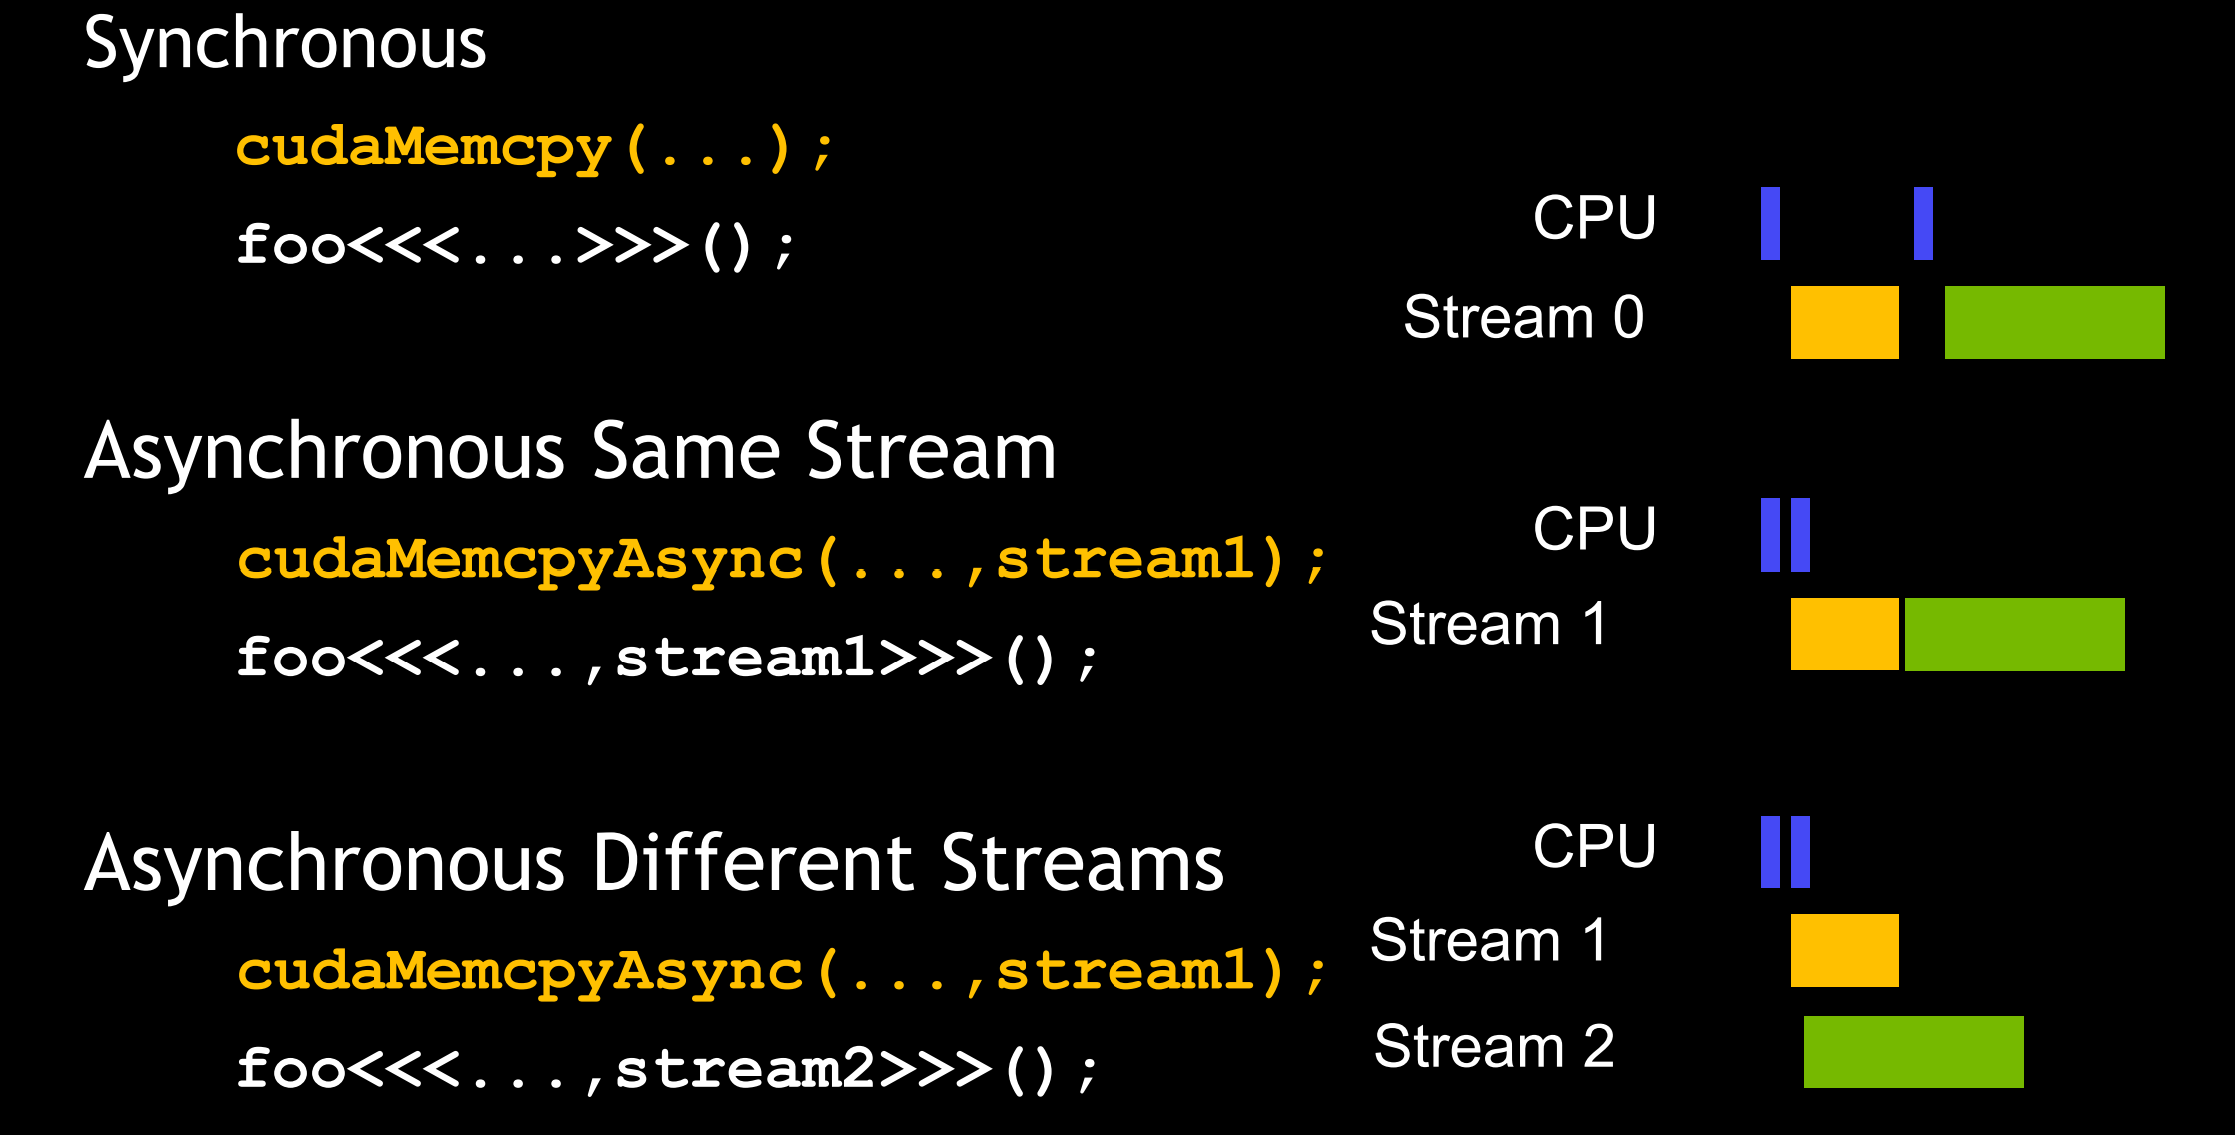

## EXAMPLE: saxpy using streams

In [ ]:
%%writefile saxpy_streams.cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <iostream>

__global__ void saxpy(float* z, float* x, float* y, float a, int n) {
    int tid=blockIdx.x*blockDim.x+threadIdx.x;
    if (tid < n)
        z[tid] = a * x[tid] + y[tid];

}
int main() {
    const int num_streams = 4;
    const int n = 1 << 26;
    float* x, * y, * z, a = 3;
    float* dx, * dy, * dz;
    int chunk_size = n / num_streams;
    int num_chunks = n / chunk_size;

    cudaMallocHost(&x, n * sizeof(float));
    cudaMallocHost(&y, n * sizeof(float));
    cudaMallocHost(&z, n * sizeof(float));
    for (int i = 0; i < n; ++i) {
        x[i] = 2;
        y[i] = 4;
    }
    cudaMalloc(&dx, n * sizeof(float));
    cudaMalloc(&dy, n * sizeof(float));
    cudaMalloc(&dz, n * sizeof(float));
    dim3 blockSize(256);
    dim3 gridSize((chunk_size + blockSize.x - 1) / blockSize.x);
    cudaStream_t streams[num_streams];
    for (int s = 0; s < num_streams; ++s)
        cudaStreamCreate(&streams[s]);
    for (int c = 0; c < num_chunks; ++c) {
        cudaMemcpyAsync(dx + c * chunk_size, x + c * chunk_size,
            chunk_size * sizeof(float), cudaMemcpyHostToDevice, streams[c]);
        cudaMemcpyAsync(dy + c * chunk_size, y + c * chunk_size,
            chunk_size * sizeof(float), cudaMemcpyHostToDevice, streams[c]);
        saxpy << <gridSize, blockSize, 0, streams[c] >> >
            (dz + c * chunk_size, dx + c * chunk_size, dy + c * chunk_size, a, chunk_size);
        cudaMemcpyAsync(z + c * chunk_size, dz + c * chunk_size,
            chunk_size * sizeof(float), cudaMemcpyDeviceToHost, streams[c]);
    }
    cudaDeviceSynchronize();
    /* cudaMemcpy(dx,x,n*sizeof(float),cudaMemcpyHostToDevice);
     cudaMemcpy(dy,y,n*sizeof(float),cudaMemcpyHostToDevice);

     saxpy<<<gridSize,blockSize>>>(dz,dx,dy,a,n);
     cudaMemcpy(z,dz,n*sizeof(float),cudaMemcpyDeviceToHost);*/
    bool err = false;
    for (int i = 0; i < n; ++i) {
        if (z[i] != 10) {
            std::cout << z[i] << "\n";
            err = true;
            break;
        }
    }
    std::cout << "Error=" << err << "\n";

}

In [ ]:
!nvcc -o saxpy_streams saxpy_streams.cu -run

In [ ]:
!nsys profile -t cuda -d 120 ./saxpy_streams

## Example 2: Average of Gaussian distribution

In the previous example the kernel consumed little time so the performance again was solely due to the overlap between memory transfers. In this example the kernel performs substantial work and it illustrates the overlap between memory transfers and computations. The kernel basically computes the average value of a gaussian distribution over a window of a chosen length

In [ ]:
%%writefile gaussian.cu
#include <math.h>
#include <iostream>

#include <stdio.h>
#include <assert.h>

class EventTimer {
public:
  EventTimer() : mStarted(false), mStopped(false) {
    cudaEventCreate(&mStart);
    cudaEventCreate(&mStop);
  }
  ~EventTimer() {
    cudaEventDestroy(mStart);
    cudaEventDestroy(mStop);
  }
  void start(cudaStream_t s = 0) { cudaEventRecord(mStart, s); 
                                   mStarted = true; mStopped = false; }
  void stop(cudaStream_t s = 0)  { assert(mStarted);
                                   cudaEventRecord(mStop, s); 
                                   mStarted = false; mStopped = true; }
  float elapsed() {
    assert(mStopped);
    if (!mStopped) return 0; 
    cudaEventSynchronize(mStop);
    float elapsed = 0;
    cudaEventElapsedTime(&elapsed, mStart, mStop);
    return elapsed;
  }

private:
  bool mStarted, mStopped;
  cudaEvent_t mStart, mStop;
};


// modifiable
typedef float real;
const int chunks = 8;
const size_t ds = 1024*1024*chunks;
const int count = 22;
const int num_streams = 8;

// not modifiable
__device__ const float sqrt_2PIf = 2.5066282747946493232942230134974f;

__device__ float gpdf(float val, float mean,float sigma) {
  return expf(-0.5f * (val-mean) * (val-mean)/sigma/sigma) / (sigma * sqrt_2PIf);
}


// compute average gaussian pdf value over a window around each point
__global__ void gaussian_pdf(const real * x, real *y, const real mean, const real sigma, const int n) {
  int idx = threadIdx.x + blockDim.x * blockIdx.x;
  if (idx < n) {
    real in = x[idx] - (count / 2) * 0.01f;
    real out = 0;
    for (int i = 0; i < count; i++) {
     // real temp = (in - mean) / sigma;
     // out += gpdf(temp, sigma);
     out+=gpdf(in,mean,sigma);
      in += 0.01f;
    }
    y[idx] = out / count;
  }
}

// error check macro
#define cudaCheckErrors(msg) \
  do { \
    cudaError_t __err = cudaGetLastError(); \
    if (__err != cudaSuccess) { \
        fprintf(stderr, "Fatal error: %s (%s at %s:%d)\n", \
            msg, cudaGetErrorString(__err), \
            __FILE__, __LINE__); \
        fprintf(stderr, "*** FAILED - ABORTING\n"); \
        exit(1); \
    } \
  } while (0)


int main() {
    EventTimer timer;

  real *h_x, *d_x, *h_y, *h_y1, *d_y;
  cudaMallocHost(&h_x,  ds*sizeof(real), cudaHostAllocDefault);
  cudaMallocHost(&h_y,  ds*sizeof(real), cudaHostAllocDefault);
  cudaMallocHost(&h_y1, ds*sizeof(real), cudaHostAllocDefault);
  cudaMalloc(&d_x, ds*sizeof(real));
  cudaMalloc(&d_y, ds*sizeof(real));
  cudaCheckErrors("allocation error");

  cudaStream_t streams[num_streams];
  for (int i = 0; i < num_streams; i++) {
    cudaStreamCreate(&streams[i]);
  }
  cudaCheckErrors("stream creation error");

  gaussian_pdf<<<(ds + 255) / 256, 256>>>(d_x, d_y, 0.0, 1.0, ds); // warm-up

  for (size_t i = 0; i < ds; i++) {
    h_x[i] = rand() / (real)RAND_MAX;
  }
  cudaDeviceSynchronize();

  timer.start();
  cudaMemcpy(d_x, h_x, ds * sizeof(real), cudaMemcpyHostToDevice);
  gaussian_pdf<<<(ds + 255) / 256, 256>>>(d_x, d_y, 0.0, 1.0, ds);
  cudaMemcpy(h_y1, d_y, ds * sizeof(real), cudaMemcpyDeviceToHost);
  timer.stop();
  std::cout<<"elapsed="<<timer.elapsed()<<"\n";
  cudaCheckErrors("non-streams execution error");


  cudaMemset(d_y, 0, ds * sizeof(real));

  timer.start();
  for (int i = 0; i < chunks; i++) { //depth-first launch
    cudaMemcpyAsync(d_x + i * (ds / chunks), h_x + i * (ds / chunks), (ds / chunks) * sizeof(real), cudaMemcpyHostToDevice, streams[i % num_streams]);
    gaussian_pdf<<<((ds / chunks) + 255) / 256, 256, 0, streams[i % num_streams]>>>(d_x + i * (ds / chunks), d_y + i * (ds / chunks), 0.0, 1.0, ds / chunks);
    cudaMemcpyAsync(h_y + i * (ds / chunks), d_y + i * (ds / chunks), (ds / chunks) * sizeof(real), cudaMemcpyDeviceToHost, streams[i % num_streams]);
  }
  cudaDeviceSynchronize();
  timer.stop();
  std::cout<<"elapsed="<<timer.elapsed()<<"\n";
  cudaCheckErrors("streams execution error");


  for (int i = 0; i < ds; i++) {
    if (h_y[i] != h_y1[i]) {
      std::cout << "mismatch at " << i << " was: " << h_y[i] << " should be: " << h_y1[i] << std::endl;
      return -1;
    }
  }


  return 0;
}

In [ ]:
!nvcc -o gaussian gaussian.cu -run

In [ ]:
!nsys profile -t cuda -d 60 ./gaussian